<h1> Data Preprocessing <h1>

In [264]:
import pandas as pd 
from datetime import datetime
# pd.set_option('display.max_rows',None)

#reading from file
receivedFileName="DataAnalytics.csv"
resaleFlatDF = pd.read_csv(receivedFileName, encoding = "ISO-8859-1")
#Drop any row with empty data
resaleFlatDF = resaleFlatDF.dropna()
resaleFlatDF = resaleFlatDF.sort_values('month', ascending=False).drop_duplicates(['block','street_name','storey_range']).sort_index()
type(resaleFlatDF)
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Latitude,Longitude
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,280000.0,1.367479,103.855967
36,2017-01,ANG MO KIO,4 ROOM,546,ANG MO KIO AVE 10,01 TO 03,92.0,New Generation,1981,63 years,410000.0,1.373651,103.857022
38,2017-01,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,04 TO 06,97.0,New Generation,1977,59 years 06 months,430000.0,1.370203,103.834688
51,2017-01,ANG MO KIO,5 ROOM,520,ANG MO KIO AVE 5,19 TO 21,118.0,Improved,1980,62 years 08 months,668000.0,1.373405,103.851134
52,2017-01,ANG MO KIO,5 ROOM,716,ANG MO KIO AVE 6,13 TO 15,119.0,Improved,1980,62 years 05 months,725000.0,1.371478,103.845869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95 years 03 months,610000.0,1.415662,103.841449
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69 years 11 months,868000.0,1.420200,103.841075
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63 years 03 months,585000.0,1.437918,103.836995
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65 years 04 months,600000.0,1.421335,103.837437


<!---
Retrieve accurate year left for remaining_lease based on the year the data is entered
-->

Transforming data to reflect accurate remaining_lease based on our current year instead of previous data.

In [265]:

for i, row in resaleFlatDF.iterrows():
   # datetime_object = datetime(2020, 2 ,2)
    year = int(row["remaining_lease"].split("years")[0])
    startDatetime = datetime.strptime(row["month"], '%Y-%m')
    #get the end date value
    currentDate = datetime.now()
    numberOfYears = (startDatetime.year + year - currentDate.year)
    resaleFlatDF.at[i, 'remaining_lease'] = numberOfYears
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Latitude,Longitude
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,57,280000.0,1.367479,103.855967
36,2017-01,ANG MO KIO,4 ROOM,546,ANG MO KIO AVE 10,01 TO 03,92.0,New Generation,1981,59,410000.0,1.373651,103.857022
38,2017-01,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,04 TO 06,97.0,New Generation,1977,55,430000.0,1.370203,103.834688
51,2017-01,ANG MO KIO,5 ROOM,520,ANG MO KIO AVE 5,19 TO 21,118.0,Improved,1980,58,668000.0,1.373405,103.851134
52,2017-01,ANG MO KIO,5 ROOM,716,ANG MO KIO AVE 6,13 TO 15,119.0,Improved,1980,58,725000.0,1.371478,103.845869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95,610000.0,1.415662,103.841449
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69,868000.0,1.420200,103.841075
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63,585000.0,1.437918,103.836995
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65,600000.0,1.421335,103.837437


Transformation of data into categories for our algorithm:

Flat type, storey_range and flat model is converted to numerical values for categorisation <br>
Resale price is categorised to intervals of \$100,000 or bigger than \$1,000,000 <br>
Remaining lease is categorised to intervals of decades <br>

In [266]:
import math

resaleFlatProcessedDF = resaleFlatDF.copy()

flatType = sorted(resaleFlatDF["flat_type"].drop_duplicates())
flatType
i = 1 
for x in flatType:
    resaleFlatProcessedDF["flat_type"] = resaleFlatProcessedDF["flat_type"].replace([x],i)
    i = i + 1   

storeyRange = sorted(resaleFlatDF["storey_range"].drop_duplicates())
storeyRange
i = 1 
for x in storeyRange:
    resaleFlatProcessedDF["storey_range"] = resaleFlatProcessedDF["storey_range"].replace([x],i)
    i = i + 1 
    
flatModel = sorted(resaleFlatDF["flat_model"].drop_duplicates())
flatModel
i = 1 
for x in flatModel:
    resaleFlatProcessedDF["flat_model"] = resaleFlatProcessedDF["flat_model"].replace([x],i)
    i = i + 1   
    
#price categorise
#price is sorted to intervals of every 100000, when above 1000000, displayed as above 1000000
resaleFlatProcessedDF['resale_price'] = resaleFlatProcessedDF['resale_price'].apply(lambda x: math.ceil(x/100000) if x < 1000000 else 11)

#remaining lease categorise
resaleFlatProcessedDF['remaining_lease'] = resaleFlatProcessedDF['remaining_lease'].apply(lambda x: math.ceil(x/10))
resaleFlatProcessedDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Latitude,Longitude
6,2017-01,ANG MO KIO,3,447,ANG MO KIO AVE 10,2,68.0,12,1979,6,3,1.367479,103.855967
36,2017-01,ANG MO KIO,4,546,ANG MO KIO AVE 10,1,92.0,12,1981,6,5,1.373651,103.857022
38,2017-01,ANG MO KIO,4,254,ANG MO KIO AVE 4,2,97.0,12,1977,6,5,1.370203,103.834688
51,2017-01,ANG MO KIO,5,520,ANG MO KIO AVE 5,7,118.0,5,1980,6,7,1.373405,103.851134
52,2017-01,ANG MO KIO,5,716,ANG MO KIO AVE 6,5,119.0,5,1980,6,8,1.371478,103.845869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5,511A,YISHUN ST 51,4,113.0,5,2017,10,7,1.415662,103.841449
100643,2021-06,YISHUN,6,664,YISHUN AVE 4,1,181.0,3,1992,7,9,1.420200,103.841075
100644,2021-06,YISHUN,6,277,YISHUN ST 22,1,152.0,7,1985,7,6,1.437918,103.836995
100645,2021-06,YISHUN,6,643,YISHUN ST 61,1,146.0,7,1987,7,6,1.421335,103.837437


Dropping data that does not help define the flat or is unnecessary:

All these variables does not define the flat <br>
Except for floor_area_sqm which is based on the flat type. Hence it is redundant

In [267]:
resaleFlatProcessedDF = resaleFlatProcessedDF.drop(['month','town','block','floor_area_sqm','street_name','lease_commence_date','Latitude','Longitude'], axis=1)
resaleFlatProcessedDF

,flat_type,storey_range,flat_model,remaining_lease,resale_price
6,3,2,12,6,3
36,4,1,12,6,5
38,4,2,12,6,5
51,5,7,5,6,7
52,5,5,5,6,8
...,...,...,...,...,...
100642,5,4,5,10,7
100643,6,1,3,7,9
100644,6,1,7,7,6
100645,6,1,7,7,6


Adding classes onto data for hierarchical clustering to transform into training data

In [268]:
resaleFlatGroupDF = resaleFlatProcessedDF.groupby(["flat_type","storey_range","flat_model","remaining_lease","resale_price"])
resaleFlatProcessedDF["Class"] = 0
category = pd.DataFrame(columns=["flat_type","storey_range","flat_model","remaining_lease","resale_price","Class"])

for i, (key, df) in enumerate(resaleFlatGroupDF):
    category = category.append({"flat_type": key[0],"storey_range": key[1],"flat_model": key[2],"remaining_lease": key[3],"resale_price": key[4], "Class": i}, ignore_index = True)
    for row in df.iterrows():
        resaleFlatDF.loc[row[0], 'Class'] = i
print(category)
resaleFlatDF


     flat_type storey_range flat_model remaining_lease resale_price Class
0            1            1          5               6            2     0
1            1            2          5               6            2     1
2            1            3          5               6            3     2
3            1            4          5               6            2     3
4            2            1          1              10            3     4
...        ...          ...        ...             ...          ...   ...
2104         7            3         11               7            8  2104
2105         7            3         11               7            9  2105
2106         7            4         11               7            7  2106
2107         7            4         11               7            9  2107
2108         7            4         11               7           10  2108

[2109 rows x 6 columns]


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Latitude,Longitude,Class
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,57,280000.0,1.367479,103.855967,205.0
36,2017-01,ANG MO KIO,4 ROOM,546,ANG MO KIO AVE 10,01 TO 03,92.0,New Generation,1981,59,410000.0,1.373651,103.857022,552.0
38,2017-01,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,04 TO 06,97.0,New Generation,1977,55,430000.0,1.370203,103.834688,628.0
51,2017-01,ANG MO KIO,5 ROOM,520,ANG MO KIO AVE 5,19 TO 21,118.0,Improved,1980,58,668000.0,1.373405,103.851134,1670.0
52,2017-01,ANG MO KIO,5 ROOM,716,ANG MO KIO AVE 6,13 TO 15,119.0,Improved,1980,58,725000.0,1.371478,103.845869,1522.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95,610000.0,1.415662,103.841449,1470.0
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69,868000.0,1.420200,103.841075,1887.0
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63,585000.0,1.437918,103.836995,1897.0
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65,600000.0,1.421335,103.837437,1897.0


<h1> Data Mining - Hierarchical Clustering </h1>

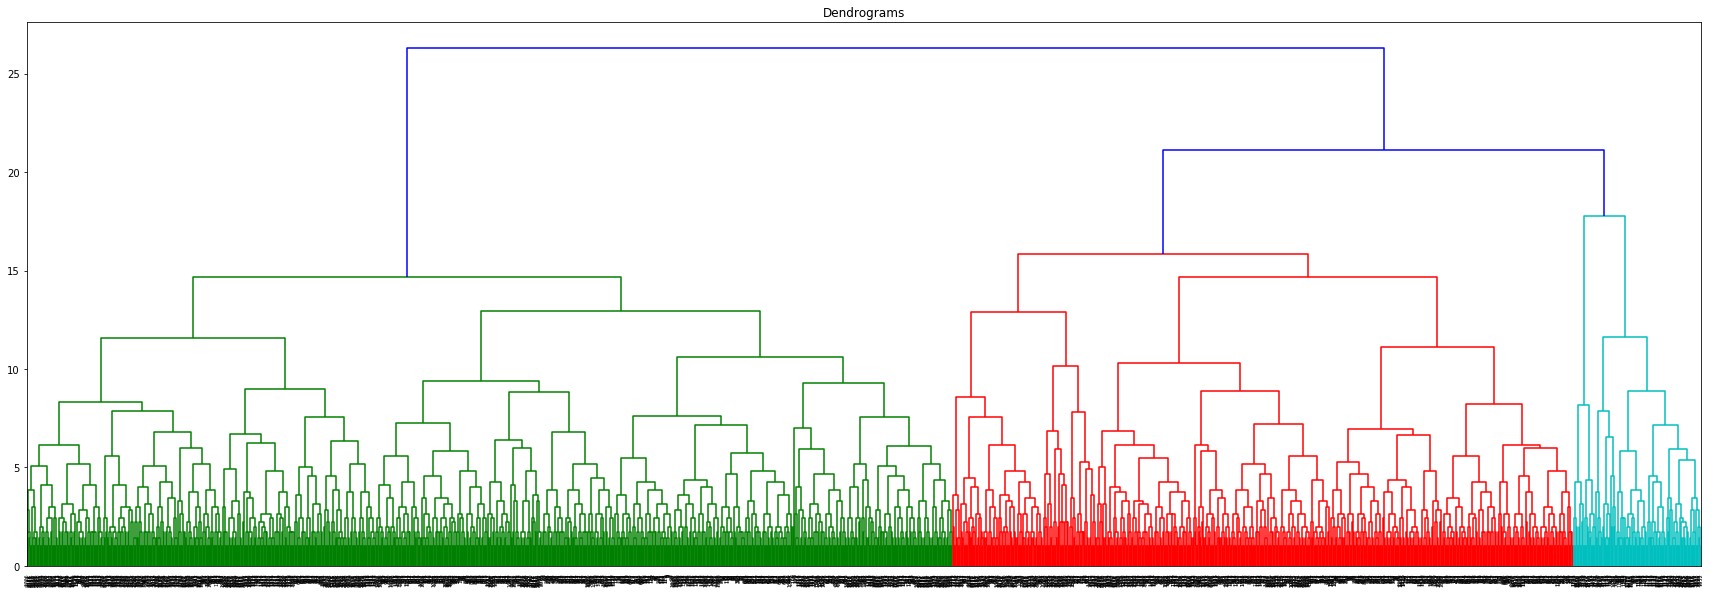

In [269]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.iloc[:,[0,1,2,3,4]].values
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

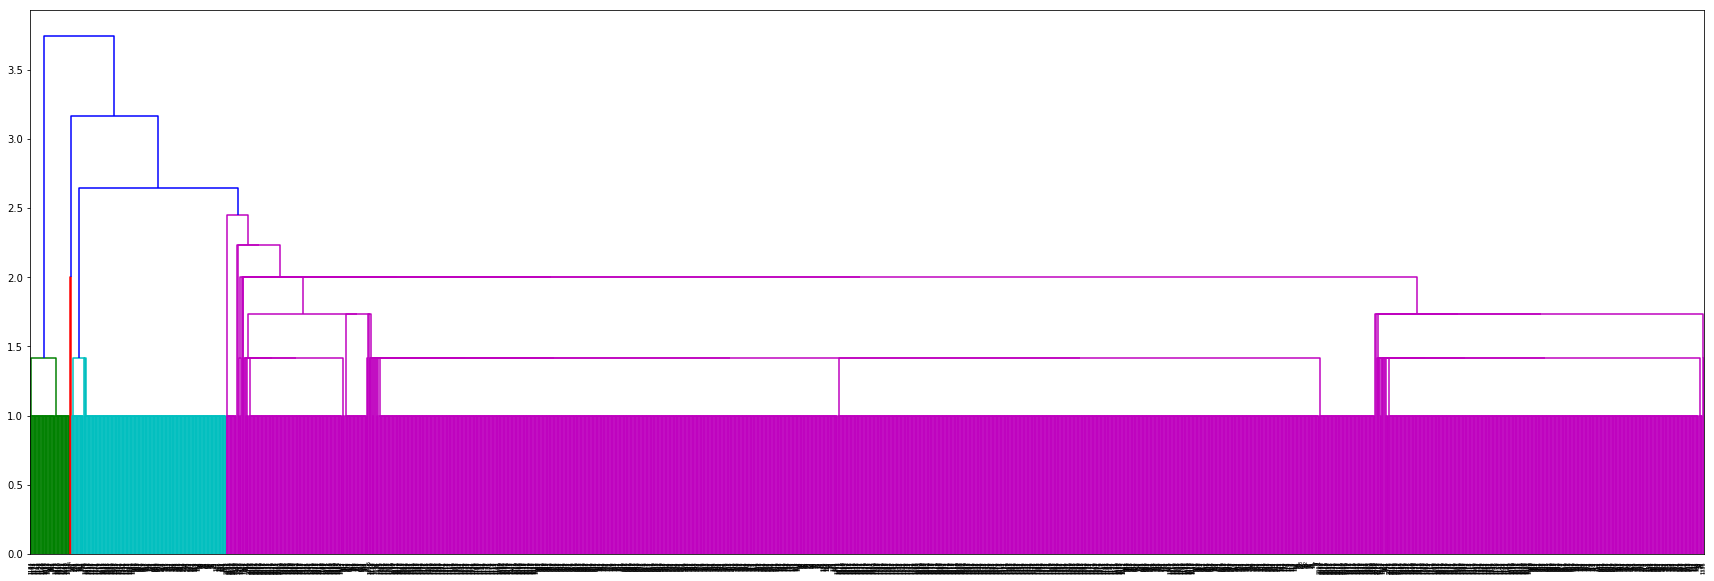

In [270]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

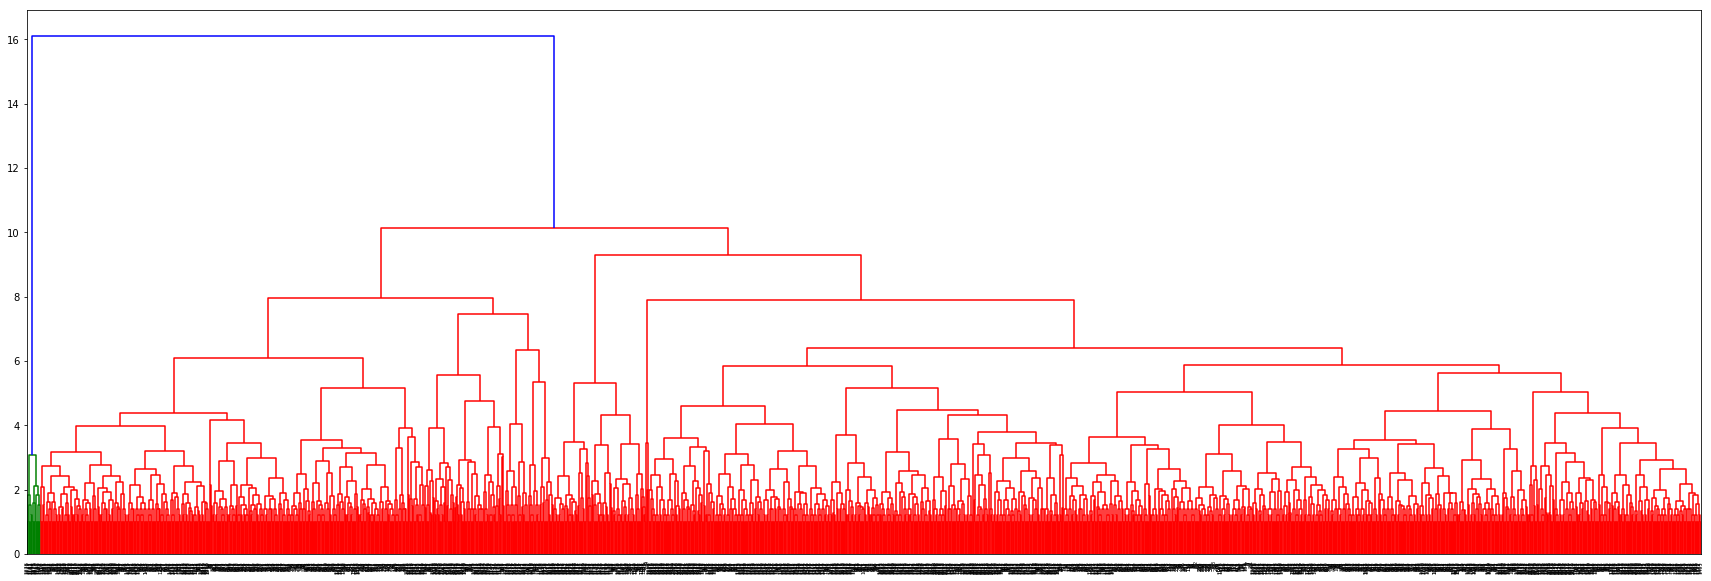

In [271]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

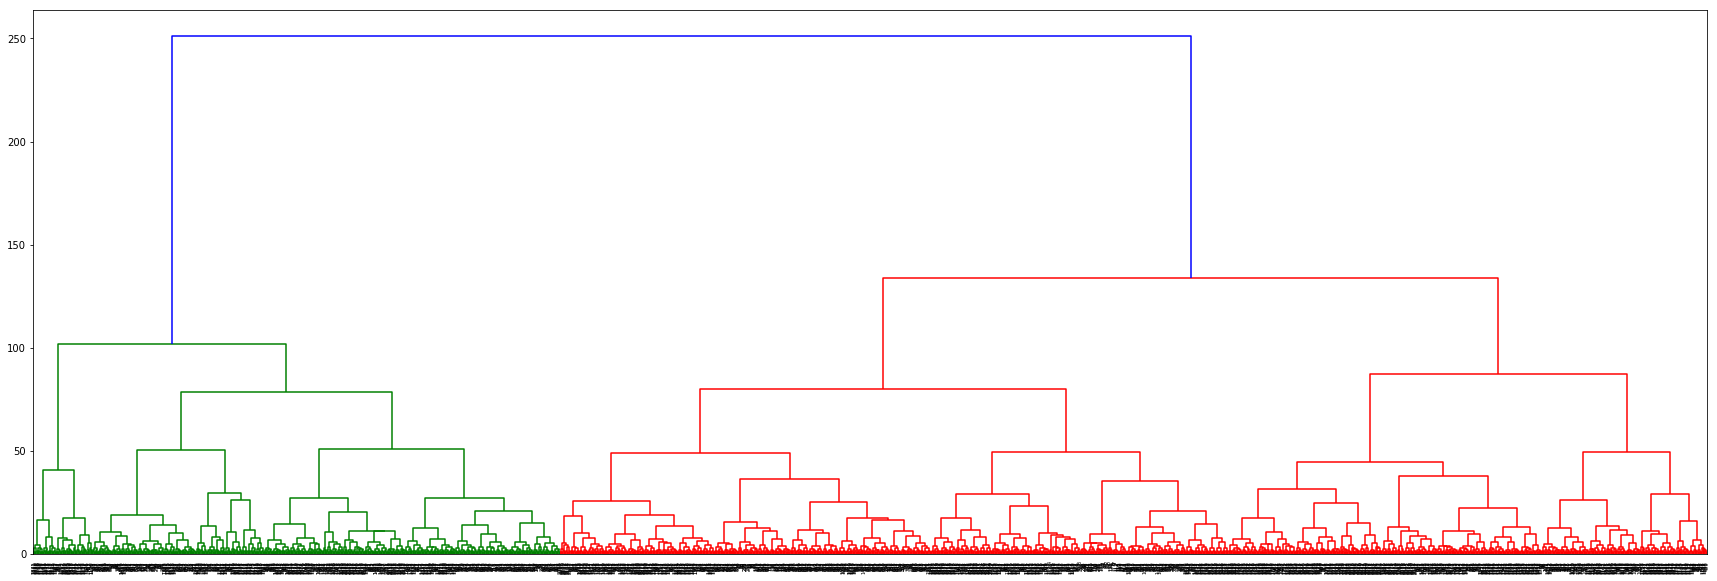

In [272]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'ward')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

From here on, based on visualization and analysis, we chose complete linkage for our hierarchical clustering. The complete clustering shows on the dendogram to have distinct clusterings compared to single link and ward link. We do not want to have clustering that are close together if not categorization of new data may be biased.

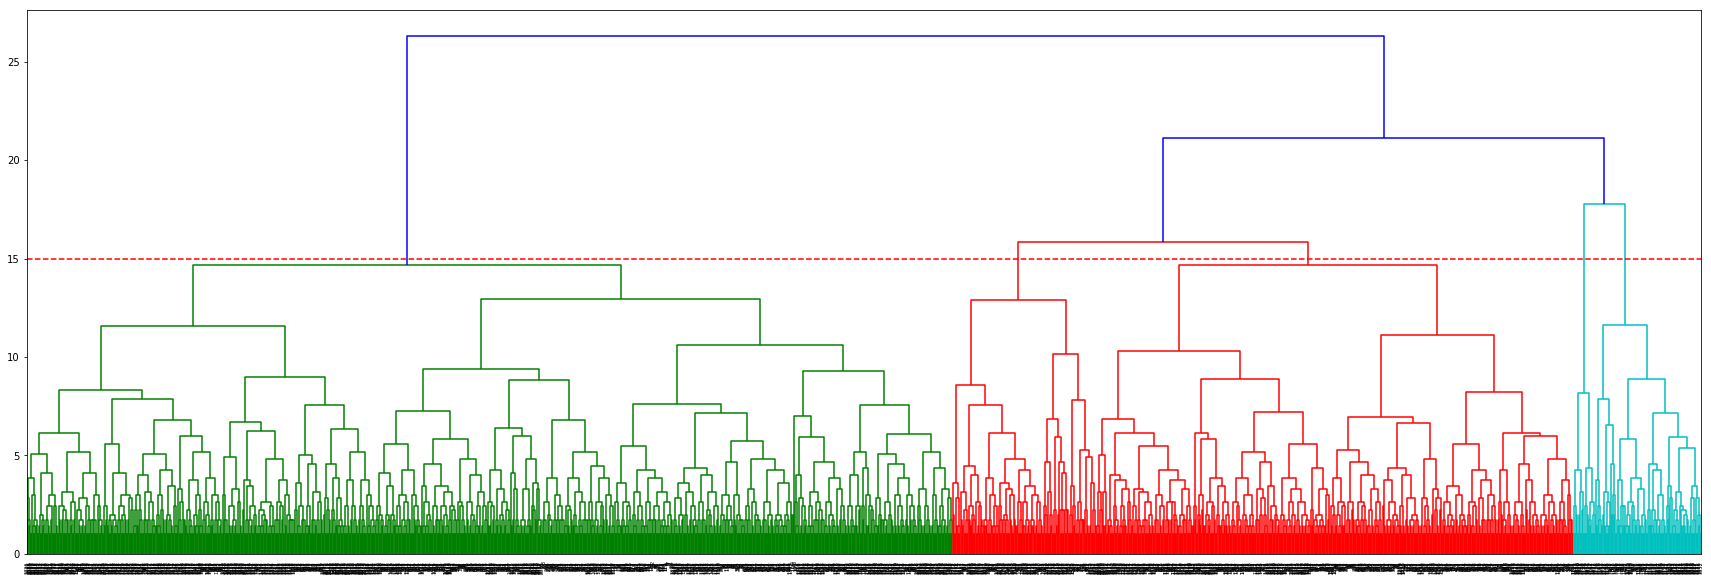

In [273]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())
plt.axhline(y=15, color='r', linestyle='--')

[0.50728762 0.31050769 0.11568803 0.04987482 0.01664184]


Text(0.5,1,'Plot of eigen variance energy captured by Principle component')

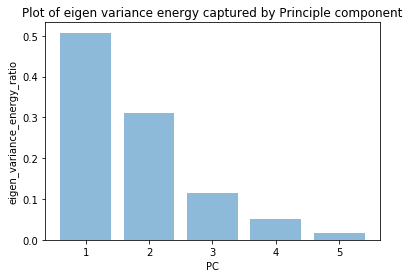

In [274]:
from sklearn.decomposition import PCA

#show all the eigen vector
pca_all = PCA()
pca_all.fit(X)

eigen_energy = pca_all.explained_variance_ratio_ 
print(eigen_energy) #show all the eigen vector
plt.bar(range(1,6),eigen_energy,alpha=0.5,align = 'center',label = 'individual explained variance')
plt.xlabel('PC')
plt.ylabel('eigen_variance_energy_ratio')
plt.title ("Plot of eigen variance energy captured by Principle component")



In [275]:
#minimum varaince must be more than 70
pca_2 = PCA (n_components = 2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X) #transform  become 1000 *2
print(X_pca_2)
print(X_pca_2.shape)

[[-3.10608648 -5.94734961]
 [-3.12938837 -5.05424074]
 [-3.23249609 -3.75946776]
 ...
 [ 2.03225411 -0.42844497]
 [ 1.87264244  0.37488324]
 [ 1.7928366   0.77654735]]
(2109, 2)


Text(0.5,1,'Projection of Data in Eigenspace')

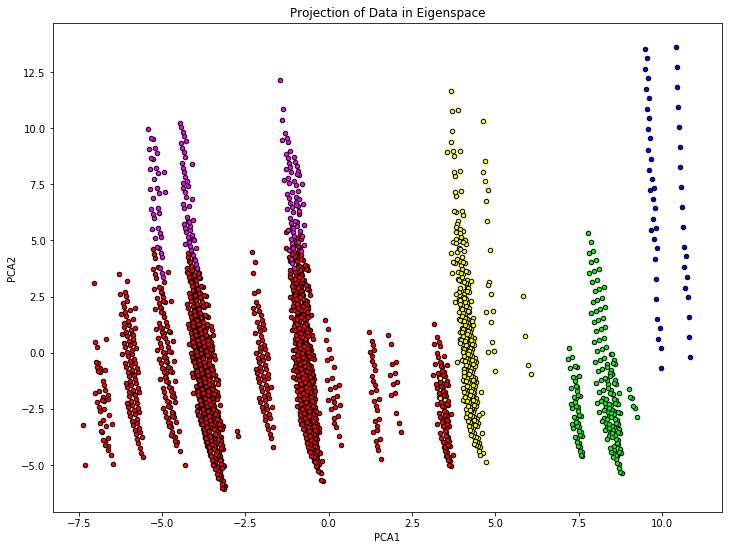

In [276]:
from sklearn.cluster import AgglomerativeClustering

# 4 clusters because of cut line from above hierarchical dendogram.
cluster = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='complete')
hc = cluster.fit_predict(X)

reds = hc == 0 #label
yellow = hc == 1
blue = hc == 2
magenta = hc == 3
lime = hc == 4

plt.figure(figsize=(12,9)) 

#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[yellow,0], X_pca_2[yellow,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[magenta,0], X_pca_2[magenta,1],c="magenta", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[lime,0], X_pca_2[lime,1],c="lime", s=20,edgecolor = 'k')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')


Text(0.5,1,'Projection of Data in Eigenspace')

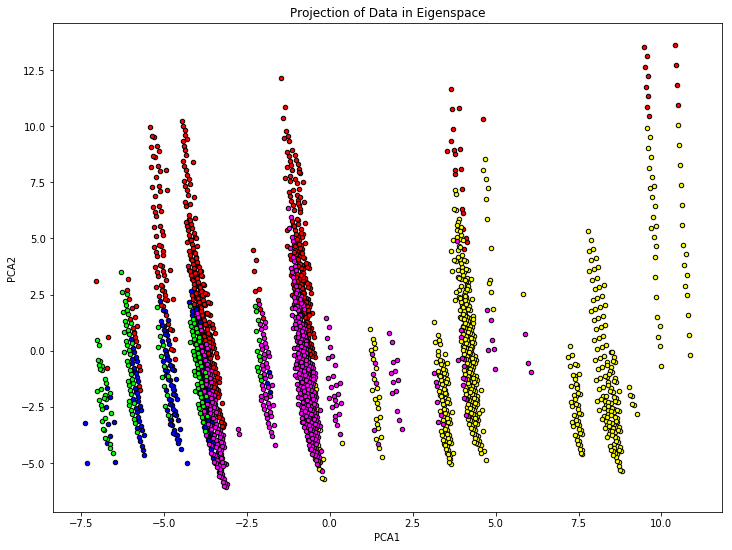

In [277]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')  
hc = cluster.fit_predict(X)
reds = hc == 0 #label
yellow = hc == 1
blue = hc == 2
magenta = hc == 3
lime = hc == 4

plt.figure(figsize=(12,9)) 


#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[yellow,0], X_pca_2[yellow,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[magenta,0], X_pca_2[magenta,1],c="magenta", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[lime,0], X_pca_2[lime,1],c="lime", s=20,edgecolor = 'k')



plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')

Text(0.5,1,'Projection of Data in Eigenspace')

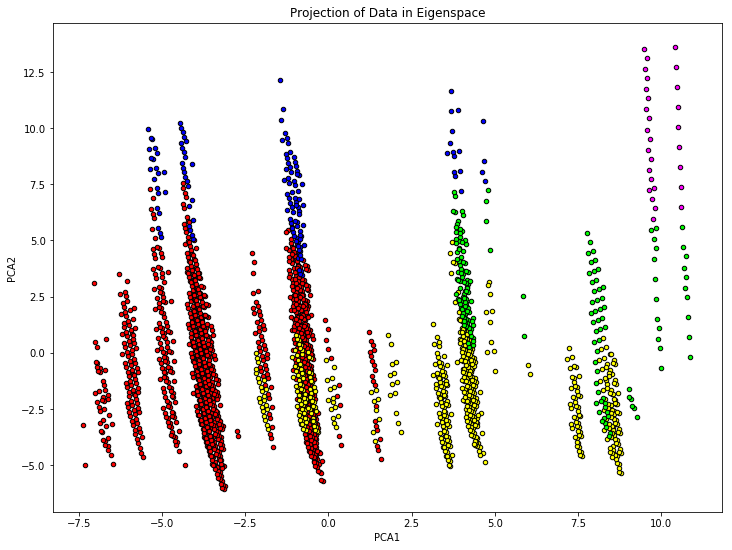

In [278]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')  
hc = cluster.fit_predict(X)
reds = hc == 0 #label
yellow = hc == 1
blue = hc == 2
magenta = hc == 3
lime = hc == 4

plt.figure(figsize=(12,9)) 


#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[yellow,0], X_pca_2[yellow,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[magenta,0], X_pca_2[magenta,1],c="magenta", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[lime,0], X_pca_2[lime,1],c="lime", s=20,edgecolor = 'k')



plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')


In [279]:
# Label for KNN data
cluster = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='complete')
hc = cluster.fit_predict(X)

category['Cluster'] = hc

<h1> KNN / DECISION TREE to find the cluster it belongs to </h1>

In [280]:
###########################################################
# Create the Training and Test set with split 70:30 
##########################################################

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, hc, test_size=0.3, random_state=12)
from sklearn import tree
from sklearn.metrics import accuracy_score


Text(0,0.5,'Accuracy')

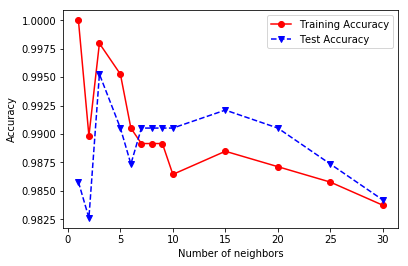

In [281]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

numNeighbors = [1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
trainAcc = []
testAcc = []

for k in numNeighbors:
    clf1 = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf1.fit(X_train, Y_train)
    Y_predTrain = clf1.predict(X_train)
    Y_predTest = clf1.predict(X_test)
    trainAcc.append(accuracy_score(Y_train, Y_predTrain))
    testAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

K=3 is the knee point for both Training and Testing data. Therefore let k=3

Text(0,0.5,'Accuracy')

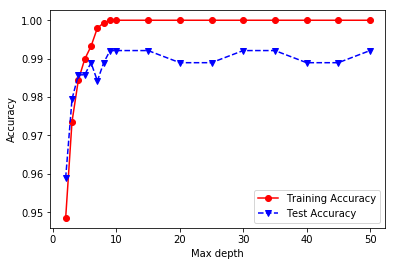

In [282]:
###########################################################################
# Model fit and performance evaluation for various tree depth from 2-50
###########################################################################
from sklearn.tree import DecisionTreeClassifier
import numpy as np
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]  # 17 different depths

trainAccuracy = np.zeros(len(maxdepths))
testAccuracy = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf2 = tree.DecisionTreeClassifier(max_depth=depth)
    clf2 = clf2.fit(X_train, Y_train)
    Y_predTrain = clf2.predict(X_train)
    Y_predTest = clf2.predict(X_test)
    
    trainAccuracy[index] = accuracy_score(Y_train, Y_predTrain)
    testAccuracy[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    
###########################################################################
# Plot training and test accuracies
##########################################################################
    
plt.plot(maxdepths,trainAccuracy,'ro-',maxdepths,testAccuracy,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

Maxdepth=6 is the knee point that is below the training line for Testing data. Therefore let Max_depth=6

Accuracy :  0.9826224328593997


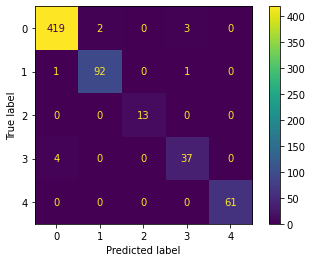

In [186]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X_pca_2, hc, test_size=0.3, random_state=12)

clf2 = tree.DecisionTreeClassifier(max_depth=6)
clf2 = clf2.fit(X_train, Y_train)
Y_predTrain = clf2.predict(X_train)
Y_predTest = clf2.predict(X_test)

cm = confusion_matrix(Y_test, Y_predTest)
print ("Accuracy : ", accuracy_score(Y_test, Y_predTest))
plot_confusion_matrix(clf2, X_test, Y_test )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

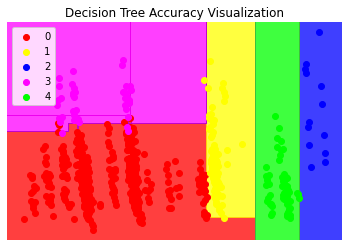

In [187]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, Y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
#Visual glitch occurred with yellow not showing
#Resolved by adding a dummy value at 3rd position of the ListedColormap
plt.contourf(X1, X2, clf2.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'yellow', 'blue', 'none', 'magenta', 'lime')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow', 'blue', 'magenta', 'lime'))(i), label = j)
plt.title('Decision Tree Accuracy Visualization')
plt.axis('off')
plt.legend()
plt.show()

Accuracy :  0.990521327014218


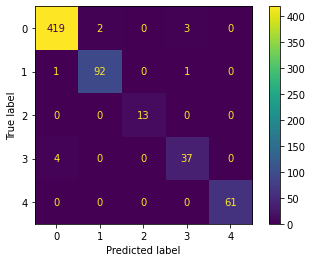

In [188]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X_pca_2, hc, test_size=0.3, random_state=12)

clf1 = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
clf1.fit(X_train, Y_train)
Y_predTrain = clf1.predict(X_train)
Y_predTest = clf1.predict(X_test)

cm = confusion_matrix(Y_test, Y_predTest)
print ("Accuracy : ", accuracy_score(Y_test, Y_predTest))
plot_confusion_matrix(clf2, X_test, Y_test )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

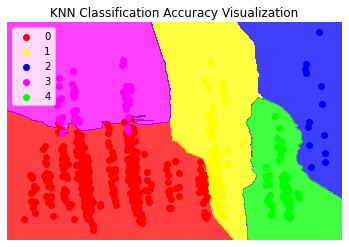

In [189]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, Y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
#Visual glitch occurred with yellow not showing
#Resolved by adding a dummy value at 3rd position of the ListedColormap
plt.contourf(X1, X2, clf1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'yellow', 'blue', 'none', 'magenta', 'lime')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'yellow', 'blue', 'magenta', 'lime'))(i), label = j)
plt.title('KNN Classification Accuracy Visualization')
plt.axis('off')
plt.legend()
plt.show()

<h1>Simulate User Input </h1>

Prepare the KNN classifier based on optimal k value

In [285]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
neigh.fit(X,hc)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Get label for each category

In [286]:
#Simulate user input
for i, item in enumerate(flatType):
    print(str(i+1) +": " + item)

1: 1 ROOM
2: 2 ROOM
3: 3 ROOM
4: 4 ROOM
5: 5 ROOM
6: EXECUTIVE
7: MULTI-GENERATION


In [287]:
for i, item in enumerate(storeyRange):
    print(str(i+1) +": " + item)

1: 01 TO 03
2: 04 TO 06
3: 07 TO 09
4: 10 TO 12
5: 13 TO 15
6: 16 TO 18
7: 19 TO 21
8: 22 TO 24
9: 25 TO 27
10: 28 TO 30
11: 31 TO 33
12: 34 TO 36
13: 37 TO 39
14: 40 TO 42
15: 43 TO 45
16: 46 TO 48
17: 49 TO 51


In [288]:
for i, item in enumerate(flatModel):
    print(str(i+1) +": " + item)

1: 2-room
2: Adjoined flat
3: Apartment
4: DBSS
5: Improved
6: Improved-Maisonette
7: Maisonette
8: Model A
9: Model A-Maisonette
10: Model A2
11: Multi Generation
12: New Generation
13: Premium Apartment
14: Premium Apartment Loft
15: Premium Maisonette
16: Simplified
17: Standard
18: Terrace
19: Type S1
20: Type S2


In [289]:
for i in range(1000001,0,-100000):
    print(str(math.ceil(i/100000) if i < 1000000 else 11)+": resale price >= "+ str(i))

11: resale price >= 1000001
10: resale price >= 900001
9: resale price >= 800001
8: resale price >= 700001
7: resale price >= 600001
6: resale price >= 500001
5: resale price >= 400001
4: resale price >= 300001
3: resale price >= 200001
2: resale price >= 100001
1: resale price >= 1


In [290]:
for i in range(101,0,-10):
    print(str(math.ceil(i/10) if i < 1000000 else 11)+": remaing lease year >= "+ str(i))

11: remaing lease year >= 101
10: remaing lease year >= 91
9: remaing lease year >= 81
8: remaing lease year >= 71
7: remaing lease year >= 61
6: remaing lease year >= 51
5: remaing lease year >= 41
4: remaing lease year >= 31
3: remaing lease year >= 21
2: remaing lease year >= 11
1: remaing lease year >= 1


In [291]:
#[flat_type, storey_range, flat_model, remaining_lease, resale_price], locationVal
#locationVal can be postal code or address
userinput = [[[4,6,5,6,2],"822166"],[[4,2,5,6,8],"542192"],[[5,3,11,8,7],"329688"],[[2,2,1,4,5],"ION"],[[1,1,16,3,5],"Chinatown Point"]]
predictions = [[neigh.predict([x[0]])[0],x[1]] for x in userinput]
predictions

[[0, '822166'],
 [0, '542192'],
 [0, '329688'],
 [0, 'ION'],
 [4, 'Chinatown Point']]

In [292]:
import requests
from geopy.distance import great_circle
distanceArr = []
for p in predictions:
    matchCluster = category.loc[category['Cluster'] == p[0]]
    origin = p[1]
    response = requests.get('https://developers.onemap.sg/commonapi/search?searchVal=' + origin + '&returnGeom=Y&getAddrDetails=Y')
    json = response.json()
    lat = json["results"][0]["LATITUDE"]
    lng = json["results"][0]["LONGTITUDE"]
    distances = []
    for i, lbl in matchCluster.iterrows():
        matchHdb = resaleFlatDF.loc[resaleFlatDF['Class'] == lbl['Class']]
        matchHdb.sort_values(by=['street_name'])
        for index, hdb in matchHdb.iterrows():
            userInputCoordinate = (lat, lng)
            flatCoordinate = (hdb["Latitude"], hdb["Longitude"])
            dist = great_circle(userInputCoordinate, flatCoordinate).km
            distances.append((index,dist))
    distances = sorted(distances, key = lambda x:x[1])
    distanceArr.append(distances)
for i, item in enumerate(distanceArr):
    print("Row index of location that is top 5 shortest distance to user input " + str(i+1) + ":")
    print(item[:5])

Row index of location that is top 5 shortest distance to user input 1:
[(53637, 0.12051606236169153), (55560, 0.12051606236169153), (31738, 0.12051606236169153), (84242, 0.12051606236169153), (53690, 0.12051606236169153)]
Row index of location that is top 5 shortest distance to user input 2:
[(47934, 4.761649616962714e-06), (79706, 4.761649616962714e-06), (82163, 4.761649616962714e-06), (82161, 4.761649616962714e-06), (79704, 4.761649616962714e-06)]
Row index of location that is top 5 shortest distance to user input 3:
[(95803, 0.06837035544384674), (33730, 0.06837035544384674), (83947, 0.06837035544384674), (81515, 0.06837035544384674), (19746, 0.06837035544384674)]
Row index of location that is top 5 shortest distance to user input 4:
[(17326, 1.4552861111278048), (99275, 1.4552861111278048), (88026, 1.4552861111278048), (80768, 1.4552861111278048), (58686, 1.4552861111278048)]
Row index of location that is top 5 shortest distance to user input 5:
[(92772, 0.26658830357278845), (8091

---------------User Input 1---------------
Flat Type: 4 ROOM
Storey Range: 16 TO 18
Flat Model: Improved
Price range >= 500001
Remaining lease >= 10

Recommendation for User Input 1:
Recommendation 1: 
month                        2019-07
town                         PUNGGOL
flat_type                     4 ROOM
block                           170A
street_name            PUNGGOL FIELD
storey_range                01 TO 03
floor_area_sqm                  93.0
flat_model                   Model A
lease_commence_date             2014
remaining_lease                   91
resale_price                370000.0
Latitude                    1.393561
Longitude                 103.914861
Class                          539.0
Name: 53637, dtype: object
Distance: 0.12km

Recommendation 2: 
month                        2019-08
town                         PUNGGOL
flat_type                     4 ROOM
block                           170A
street_name            PUNGGOL FIELD
storey_range                16 

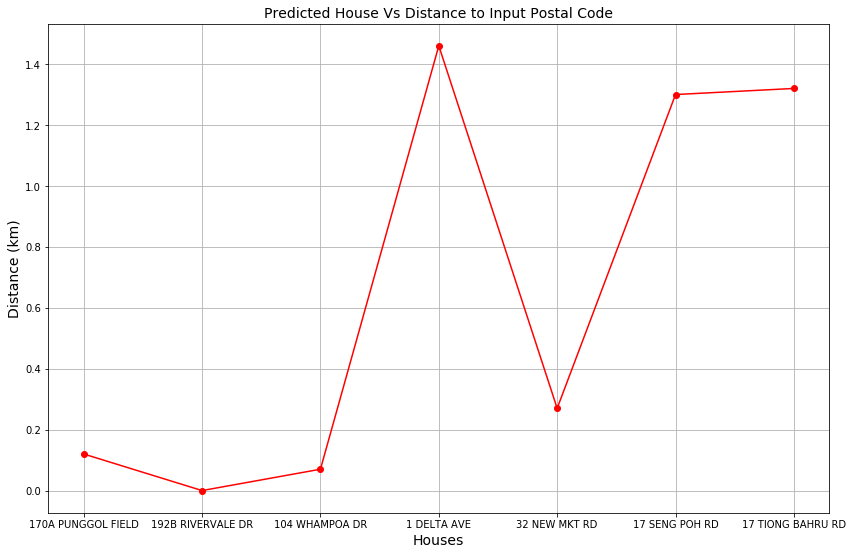

In [293]:
distance = []
location = []
for i, item in enumerate(distanceArr):
    print("---------------User Input " + str(i+1) + "---------------")
    print("Flat Type: " + flatType[userinput[i][0][0] - 1])
    print("Storey Range: " + storeyRange[userinput[i][0][1] - 1])
    print("Flat Model: " + flatModel[userinput[i][0][2] - 1])
    print("Price range >= " + str((userinput[i][0][3] - 1) * 100000 + 1))
    print("Remaining lease >= " + str((userinput[i][0][4] - 1) * 10))
    print()
    print("Recommendation for User Input " + str(i+1) + ":")
    for n in range(0,5):
        dist = "{:.2f}".format(item[n][1])
        flat = resaleFlatDF.loc[item[n][0]]
        print("Recommendation "+ str(n+1) +": \n"+ str(flat))
        print("Distance: "+ dist+ "km\n")
        loc = flat['block'] + " " + flat['street_name']
        if not loc in location:
            distance.append(float(dist))
            location.append(loc)
print(location, distance)
plt.figure(figsize=(14,9)) 
plt.plot(location, distance, color='red', marker='o')
plt.title('Predicted House Vs Distance to Input Postal Code', fontsize=14)
plt.xlabel('Houses', fontsize=14)
plt.ylabel('Distance (km)', fontsize=14)
plt.grid(True)
plt.show()